In [28]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from collections import deque, defaultdict
from plot_utils import *
env_exp_dir = Path.cwd()/env_name/'distributed'

In [29]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [30]:
runs_dict = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda: defaultdict(list)))) #exp dict: runs dict: learning_step_dict: stats_dict: list
for experiment_name in experiment_list:
    current_exp_dir = env_exp_dir/experiment_name
    runs = (runs_dir(current_exp_dir))
    runs.sort()
    for run in runs:
        current_run_dir = current_exp_dir/run
        actors_csvs = actors_dir(current_run_dir)
        actors_csvs.sort()
        for actor_csv in actors_csvs:
            df =pd.read_csv(current_run_dir/actor_csv, index_col = 0)
            for index, row in df.iterrows():
                runs_dict[experiment_name][run][index]['mean'].append(row['return_mean'])
                runs_dict[experiment_name][run][index]['std'].append(row['return_std'])
                runs_dict[experiment_name][run][index]['num_samples'].append(row['num_samples'])
                runs_dict[experiment_name][run][index]['num_success'].append(row['num_success'])

/home/jmlouw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.


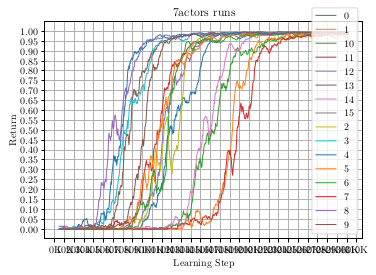

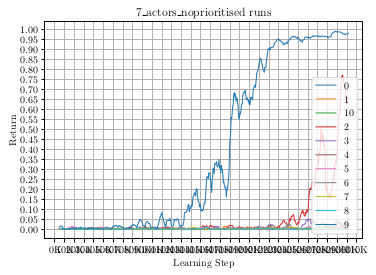

In [31]:
x_ticks = np.arange(0, 1000001, step = 10000)
y_ticks = np.arange(0, 1.05, step = 0.05)

y_ticks_per = np.arange(0, 100, step = 10)

for experiment_name in experiment_list:
    fig = create_std_fig(f'{experiment_name} runs', 'Learning Step', 'Return', x_ticks, y_ticks)
    plt.xticks(x_ticks, ['{:.0f}'.format(x) + 'K' for x in x_ticks/1000])

    smooth_len = 10

    for index,( actor, actor_values) in enumerate(runs_dict[experiment_name].items()):
        mean_returns_deq = deque(maxlen = smooth_len)
        std_deq = deque(maxlen = smooth_len)
        num_samples_deq = deque(maxlen=smooth_len)
        success_rates_deq = deque(maxlen = smooth_len)


        learning_steps = []
        mean_returns = []
        devs = []
        success_rates = []

        for learning_step, learning_step_values in actor_values.items():
            means, stds, num_samples, num_success = learning_step_values.values()

            mean_returns_deq.append(means)
            std_deq.append(stds)
            num_samples_deq.append(num_samples)
            success_rates_deq.append(num_success)
            if len(mean_returns_deq) >= mean_returns_deq.maxlen:
                mean, std = deviance(flatten_deque(mean_returns_deq), flatten_deque(std_deq), flatten_deque(num_samples_deq))
                learning_steps.append(learning_step)
                mean_returns.append(mean)
                devs.append(std)
                success_rates.append(100*(np.sum(flatten_deque(success_rates_deq))/np.sum(flatten_deque(num_samples_deq))))             

        mean_returns = [mean for _,mean in sorted(zip(learning_steps,mean_returns))]
        devs = [mean for _,mean in sorted(zip(learning_steps,devs))]
        success_rates = [mean for _,mean in sorted(zip(learning_steps,success_rates))]
        learning_steps.sort()

        plt.plot(learning_steps, mean_returns, label=actor, linewidth = 1)

    plt.legend(loc = 'lower right')
    plt.show()